In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt
from torchvision import models

In [20]:

# Define a class for applying random style deformations to images
class RandomStyleDeformation:
    def __init__(self, deformation_list):
        self.deformation_list = deformation_list

    def __call__(self, image):
        # Randomly select a style deformation function from the list
        deformation_func = random.choice(self.deformation_list)
        
        # Apply the selected deformation to the image
        return deformation_func(image)

# Define a random rotation style deformation function
def style_deformation_1(image):
    # Apply a random color jitter transformation
    color_jitter = transforms.ColorJitter(
        brightness=random.uniform(0.8, 1.2),
        contrast=random.uniform(0.8, 1.2),
        saturation=random.uniform(0.8, 1.2),
        hue=random.uniform(0.1, 0.2)
    )
    image = color_jitter(image)
    return image



# List of style deformation functions
deformation_list = [style_deformation_1]

# Create a RandomStyleDeformation object
random_style_deformation = RandomStyleDeformation(deformation_list)


In [21]:

# Define a custom dataset for your test images
class TestImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        if self.transform:
            image = self.transform(image)
        return image

# Path to your test images
image_paths = ['data/1674921468776855 (2).jpeg', 'data/16805902646928945 (2).jpeg', 'data/1687724324700842 (2).jpeg']


# Define the height and width for resizing
height, width = 1536, 1536

# Define image transformations (you can adjust these as needed)
image_transform = transforms.Compose([
    transforms.Resize((height, width)),  # Resize your images to the desired size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Create a DataLoader for your test images
test_dataset = TestImageDataset(image_paths, transform=image_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size 1 to process one image at a time

efficientNet_transform = models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()

In [22]:

# Define the MatrixProductModel
class MatrixProductModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MatrixProductModel, self).__init__()
        
        self.R = nn.Parameter(torch.randn(input_dim, output_dim), requires_grad=True)
        self.Q = nn.Parameter(torch.randn(output_dim, input_dim), requires_grad=True)

    def forward(self, x, T):
        # Perform matrix-vector multiplication Q^T * T * R * x
        y =  torch.matmul(torch.matmul(torch.matmul(x, self.R), T), self.Q)
        return y

# Define the NeuralPreset model with nn.ModuleList that containes efficientnet_b0, model_n, model_s
class NeuralPreset(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralPreset, self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim

        self.model_n =  MatrixProductModel(input_dim, output_dim)
        self.model_s =  MatrixProductModel(input_dim, output_dim)
        # self.efficientnet_b0 = models.EfficientNetB0(pretrained=True) in case if you want to download the custom model
        self.efficientnet_b0 = torch.load('efficientnet_b0.pth').eval()
        
        # Replace the final classifier with a new fully connected layer which ouputs 2*output_dim*output_dim tensor
        in_features = self.efficientnet_b0.classifier.in_features
        self.efficientnet_b0.classifier = nn.Linear(in_features, 2 * output_dim * output_dim)  # 2 stands for two vectors, r and d
        # Freeze the first layer
        for i, layer in enumerate(self.efficientnet_b0.children()):
            if i < 2:
                for param in layer.parameters():
                    param.requires_grad = False

    def forward(self, x1, x2):
        # Get T from the encoder
        downsampled_x1 = efficientNet_transform(x1)
        downsampled_x2 = efficientNet_transform(x2)

        # Output features = 256, so k is fixed to 16
        # d_i, r_i - normalized color space, color style
        d_1, r_1 = self.efficientnet_b0(downsampled_x1).chunk(2, dim=1)
        d_2, r_2 = self.efficientnet_b0(downsampled_x2).chunk(2, dim=1)

        # Perform operations using model_n and model_s
        k = self.output_dim
        Z_1 = self.model_n(x1.reshape(-1, 3), d_1.reshape(k, k))
        Z_2 = self.model_n(x2.reshape(-1, 3), d_2.reshape(k, k))

        Y_1 = self.model_s(Z_2, r_1.reshape(k, k))
        Y_2 = self.model_s(Z_1, r_2.reshape(k, k))
        

        return Z_1, Z_2, Y_1, Y_2
    
    def modeln(self, image, d):
        '''Based on the image and content vector d return color-normolized image

        Args:
            image (_type_): _description_
            d (_type_): _description_

        Returns:
            _type_: _description_
        '''        
        k = self.output_dim
        Z = self.model_n(image.reshape(-1, 3), d.reshape(k, k))
        return Z
    
    def models(self, image, r):
        '''Based on the image and style vector r returns stylized image

        Args:
            image (_type_): _description_
            r (_type_): _description_

        Returns:
            _type_: _description_
        '''        
        k = self.output_dim
        Y = self.model_s(image.reshape(-1, 3), r.reshape(k, k))
        return Y
    def encoder(self, image):
        '''Downsaples the image and returns content vector d and style vector r
        Args:
            image (_type_): _description_
        Returns:
            _type_: _description_
        '''        
        downsampled = efficientNet_transform(image)
        d, r = self.efficientnet_b0(downsampled).chunk(2, dim=1)
        return d, r
    
# Custom loss function that combines L1 norms and L2 norm
def custom_loss(Z_1, Z_2, Y_1, Y_2, I_1, I_2, coef_l):
    # Calculate L2 norm
    l2_norm = F.mse_loss(Z_1, Z_2)

    # Calculate L1 norms
    l1_norm1 = F.l1_loss(Y_1, I_1)
    l1_norm2 = F.l1_loss(Y_2, I_2)

    # Combine the L1 norms as needed
    loss = coef_l * l2_norm + l1_norm1 + l1_norm2
    
    return loss


In [23]:
# Set the number of classes in your task (adjust as needed)
k = 16

# Lambda coefficient
coef_l = 10

# Initialize the model and optimizer with Adam
model = NeuralPreset(3,k)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 150


In [24]:

for epoch in tqdm(range(num_epochs)):
    model.train() 

    for image in test_dataloader:

        # Get random style transformations
        x1 = random_style_deformation(image)
        x2 = random_style_deformation(image)

        Z_1, Z_2, Y_1, Y_2 = model(x1,x2)

        optimizer.zero_grad()

        # Calculate loss, coef lambda = 10
        loss = custom_loss(Z_1, Z_2, Y_1, Y_2, x1.reshape(-1, 3), x2.reshape(-1, 3), coef_l)
        loss.backward()

        optimizer.step()
        
        # Print the loss value at each step
        print("Epoch {}: Loss = {:.4f}".format(epoch, loss.item()))


  0%|          | 0/150 [00:00<?, ?it/s]

c:\Users\dimav\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0: Loss = 9.8591
Epoch 0: Loss = 1367.8771
Epoch 0: Loss = 47.2104
Epoch 1: Loss = 60.0381
Epoch 1: Loss = 242.3167
Epoch 1: Loss = 386.2433
Epoch 2: Loss = 46.3465
Epoch 2: Loss = 998.6816
Epoch 2: Loss = 10.9267
Epoch 3: Loss = 25.4372
Epoch 3: Loss = 63.7250
Epoch 3: Loss = 180.4450
Epoch 4: Loss = 7.5503
Epoch 4: Loss = 2.6842
Epoch 4: Loss = 78.5266
Epoch 5: Loss = 15.2936
Epoch 5: Loss = 263.1776
Epoch 5: Loss = 130.4344
Epoch 6: Loss = 54.4790
Epoch 6: Loss = 66.1168
Epoch 6: Loss = 168.7340
Epoch 7: Loss = 78.9469
Epoch 7: Loss = 610.1559
Epoch 7: Loss = 152.5584
Epoch 8: Loss = 7.0749
Epoch 8: Loss = 37.4251
Epoch 8: Loss = 138.9943
Epoch 9: Loss = 27.1271
Epoch 9: Loss = 93.0813
Epoch 9: Loss = 148.0686
Epoch 10: Loss = 38.6291
Epoch 10: Loss = 1.2460
Epoch 10: Loss = 1.2617
Epoch 11: Loss = 8.0555
Epoch 11: Loss = 21.7057
Epoch 11: Loss = 45.4437
Epoch 12: Loss = 20.0209
Epoch 12: Loss = 1.9433
Epoch 12: Loss = 222.7776
Epoch 13: Loss = 9.7700
Epoch 13: Loss = 118.0870

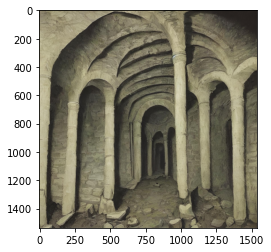

In [25]:
# Evaluate the trained model on an image
model.eval()

image_c = Image.open('data/1687724324700842 (2).jpeg')
plt.imshow(image_c)

In [31]:
# Transform the image for inference
image_transformed = image_transform(image_c).unsqueeze(0)  # Add a batch dimension

# Perform inference
with torch.no_grad():
    # Perform necessary transformations using the model
    d, r = model.encoder(image_transformed)
    Z = model.modeln(image_transformed, d)
    Y = model.models(Z, r)


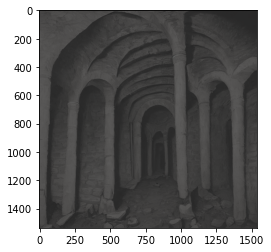

In [32]:
plt.imshow(random_style_deformation(image_transformed).view(3, height, width).permute(1, 2, 0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


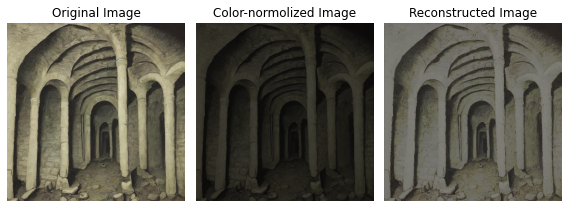

In [33]:
# Display the original image and the transformed image
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image_c)
plt.axis('off')

# Transformed Image
plt.subplot(1, 3, 2)
plt.title('Color-normolized Image')
plt.imshow(Z.view(3, height, width).permute(1, 2, 0).numpy())
plt.axis('off')

# Transformed Image
plt.subplot(1, 3, 3)
plt.title('Reconstructed Image')
plt.imshow(Y.view(3, height, width).permute(1, 2, 0).numpy())
plt.axis('off')

plt.tight_layout()
plt.show()

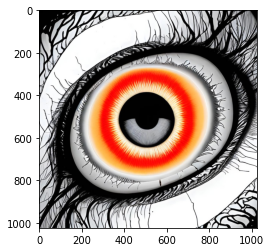

In [34]:

image_s = Image.open('data/16805902646928945 (2).jpeg')
plt.imshow(image_s)

In [37]:
# Transform the image for inference
image_transformed_s = image_transform(image_s).unsqueeze(0)  # Add a batch dimension

# Perform inference
with torch.no_grad():
    # Perform necessary transformations using the model
    d_s, r_s = model.encoder(image_transformed_s)
    Z_s = model.modeln(image_transformed_s, d_s)
    Y_s = model.models(Z_s, r_s)
    Y_modified = model.models(Z_s,r)


c:\Users\dimav\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


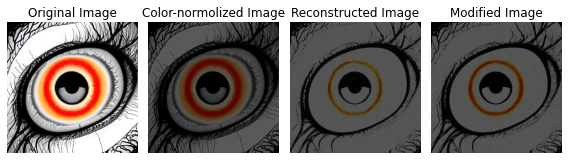

In [38]:
# Display the original image and the transformed image
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 4, 1)
plt.title('Original Image')
plt.imshow(image_s)
plt.axis('off')

# Transformed Image
plt.subplot(1, 4, 2)
plt.title('Color-normolized Image')
plt.imshow(Z_s.view(3, height, width).permute(1, 2, 0).numpy())
plt.axis('off')

# Transformed Image
plt.subplot(1, 4, 3)
plt.title('Reconstructed Image')
plt.imshow(Y_s.view(3, height, width).permute(1, 2, 0).numpy())
plt.axis('off')

# Transformed Image
plt.subplot(1, 4, 4)
plt.title('Modified Image')
plt.imshow(Y_modified.view(3, height, width).permute(1, 2, 0).numpy())
plt.axis('off')

plt.tight_layout()
plt.show()